In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from math import comb
import math
import os
import json
from pathlib import Path
from utils import BaseImage, create_mask, apply_mask, create_anchors, StringArtImage, make_line_dict, create_string_art, save_string_art, open_importance_maps, outline_importance_map, combine_importance_maps, load_string_art
import pickle
import cv2
import random

In [2]:
def display_images(image_list):
    if not isinstance(image_list, list):
        image_list = [image_list]  # Make sure image_list is a list for consistent processing

    num_images = len(image_list)
    
    # Adjust for single image case
    if num_images == 1:
        fig, axes = plt.subplots(figsize=(10, 10))
        axes = [axes]  # Make axes a list for consistent processing
    else:
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 8, 8))
    
    for ax, img in zip(axes, image_list):
        ax.imshow(img.T, cmap="gray_r")
        ax.axis('off')  # Turn off axis numbers and ticks
    
    plt.tight_layout()
    plt.show()

In [3]:
def display_importance(importance_map):
    plt.figure(figsize=(10,10))
    plt.imshow(importance_map.T, cmap='RdBu_r')
    plt.colorbar()
    plt.show()

In [4]:
base_img = BaseImage(path="./data/tom.jpg", resize_to=1400)
mask = create_mask(base_img.img)
base_img.img = apply_mask(base_img.img, mask)
anchors = create_anchors(img=base_img.img, num_anchors=288)

[[-700]
 [-699]
 [-698]
 ...
 [ 697]
 [ 698]
 [ 699]]


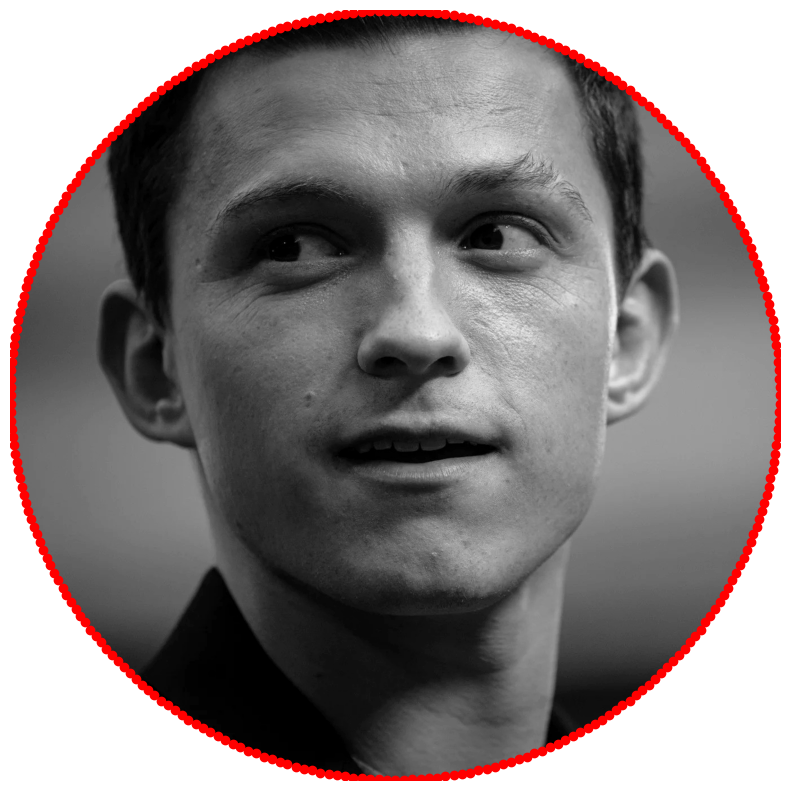

In [5]:
plt.figure(figsize=(10, 10))  
plt.imshow(base_img.img.T, cmap='gray_r')
anchors_x = [anchor.coordinates[0] for anchor in anchors]
anchors_y = [anchor.coordinates[1] for anchor in anchors]
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()  

In [6]:
string_art_img = StringArtImage(base_image=base_img, anchors=anchors, line_darkness=0.2, mask=mask)

In [7]:
importance_maps = open_importance_maps(folder_path="./data/importance_maps/tom/", string_art_img_shape=string_art_img.img.shape)

In [8]:
outline_importance_maps = []
for map in importance_maps:
    outline_map = outline_importance_map(importance_map=map, edge_thickness=3)
    outline_importance_maps.append(outline_map)

In [9]:
for map in importance_maps:
    map.img *= 1.5
for map in outline_importance_maps:
    map.img *= 2.5

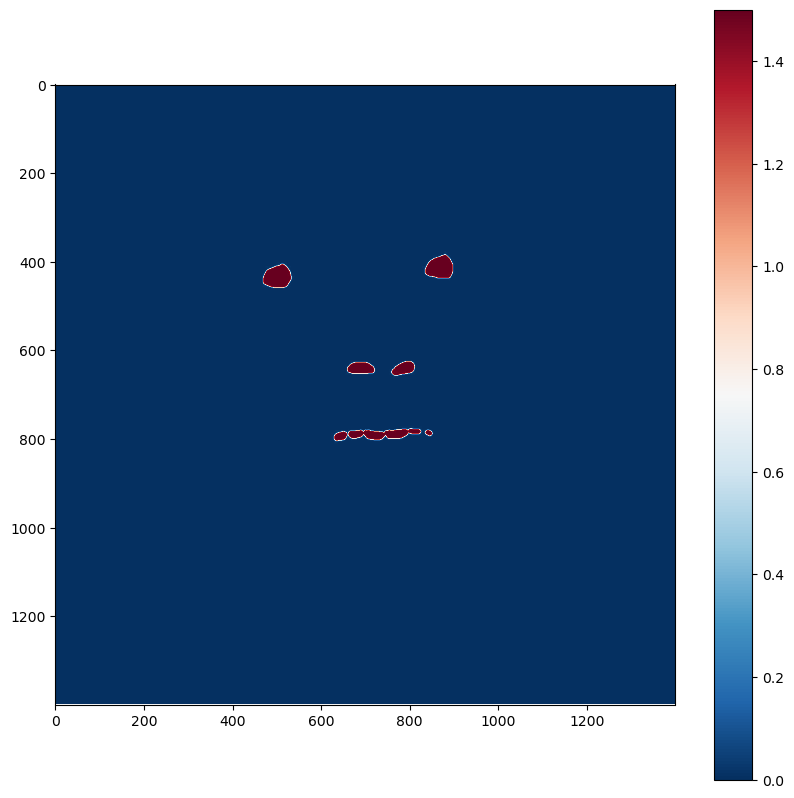

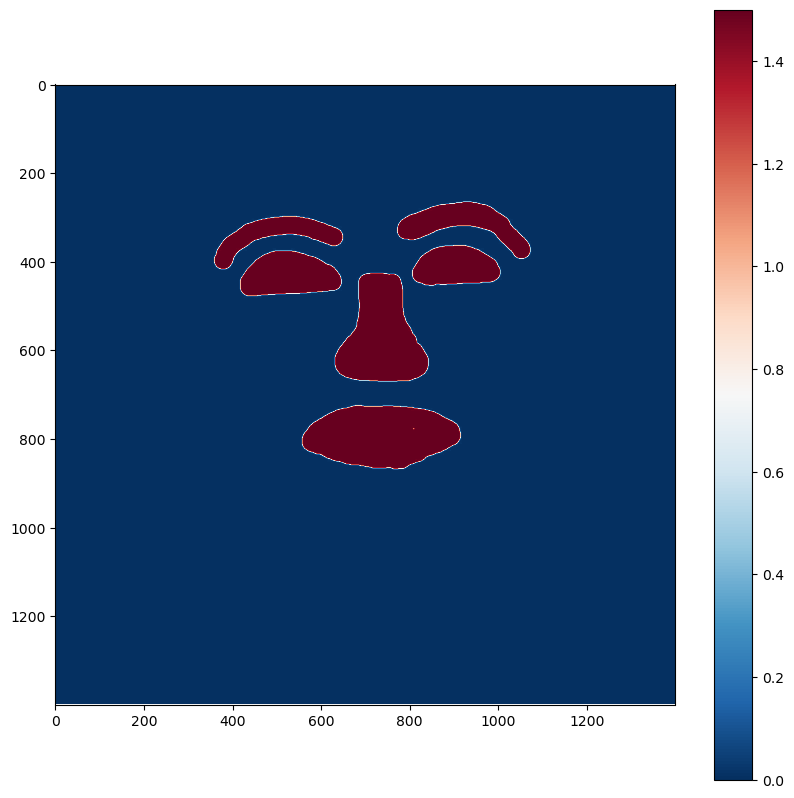

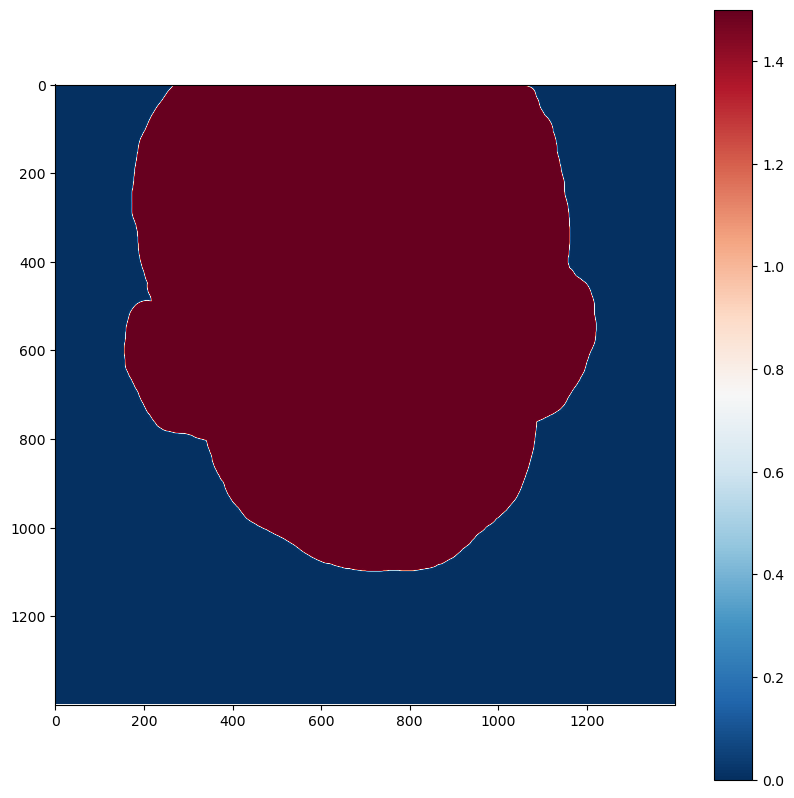

In [10]:
for map in importance_maps:
    display_importance(importance_map=map.img)

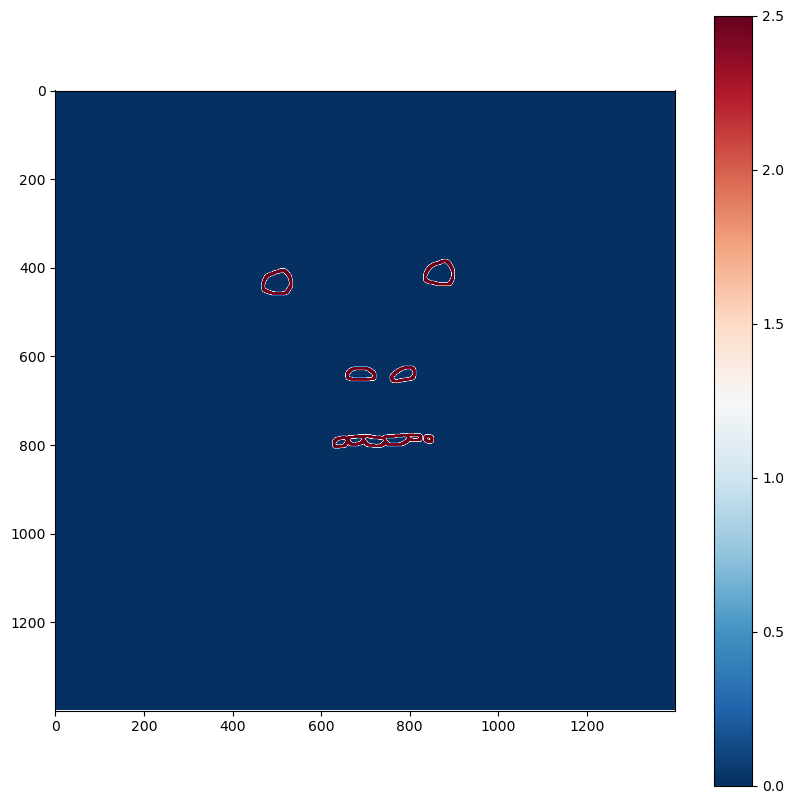

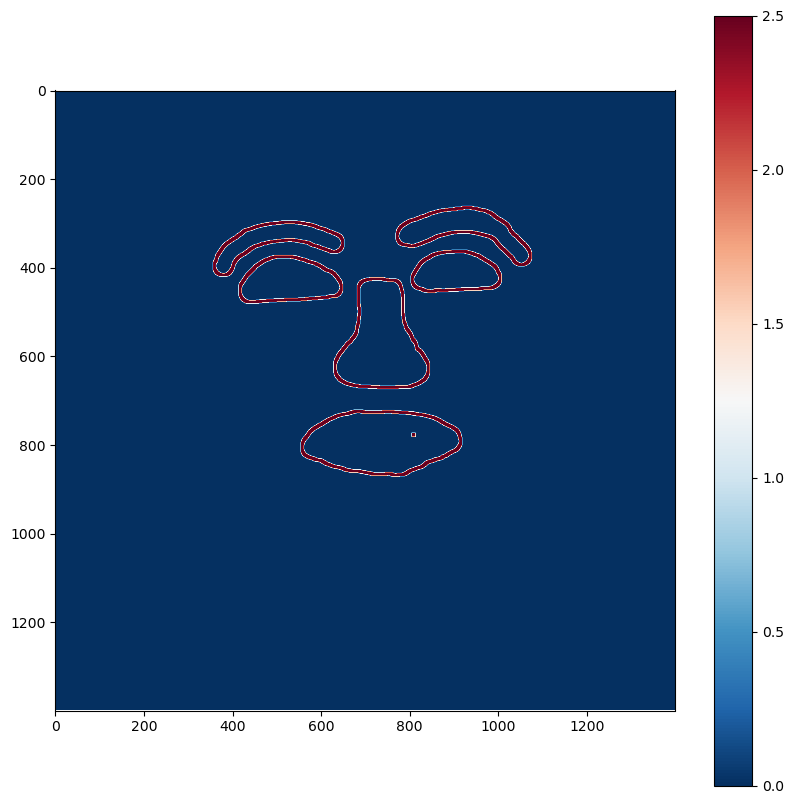

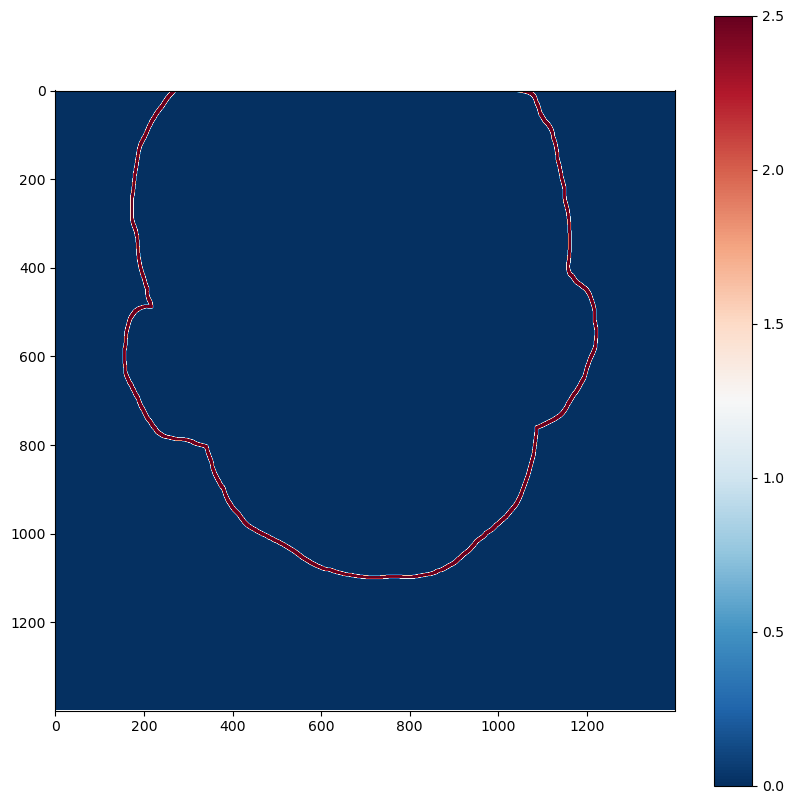

In [11]:
for map in outline_importance_maps:
    display_importance(map.img)

In [12]:
all_importance_maps = importance_maps + outline_importance_maps
main_importance_map = combine_importance_maps(all_importance_maps)
main_importance_map.apply_gaussian_blur(25)
main_importance_map.apply_dynamic_sigmoid(1)

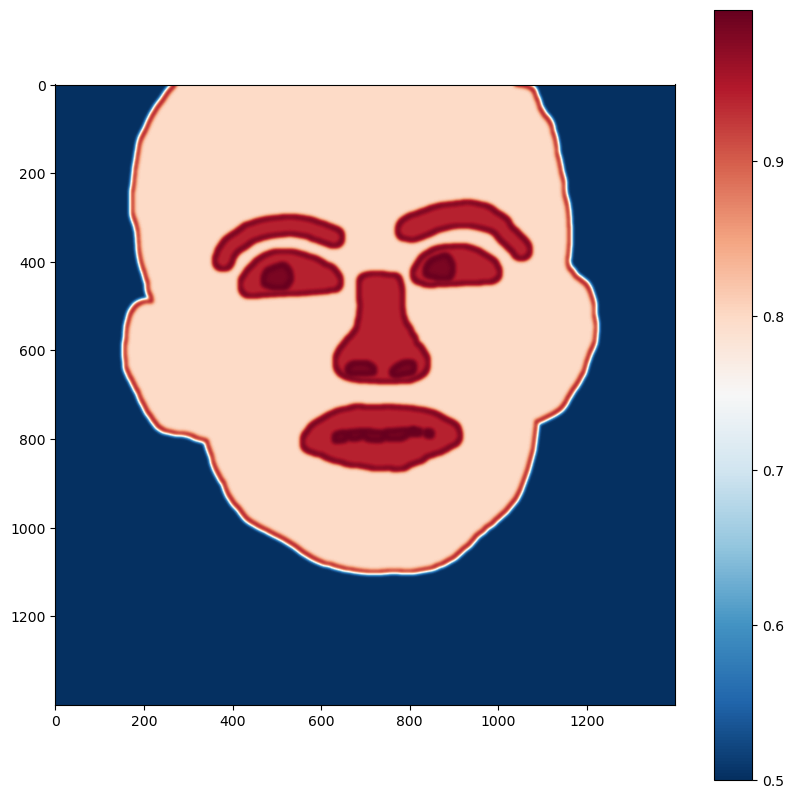

In [13]:
display_importance(main_importance_map.img)

In [14]:
line_pixel_dict, line_darkness_dict = make_line_dict(
    data_folder="./data",
    string_art_img=string_art_img,
    closest_neighbors=10,
)

Opening existing line dictionary
Done!


In [15]:
final_img= create_string_art(
    first_anchor=0,
    base_img=base_img.img,
    string_art_img=string_art_img,
    line_pixel_dict=line_pixel_dict,
    line_darkness_dict=line_darkness_dict,
    iterations=5000,
    loss_method="difference_img",
    max_darkness=1,
    importance_map=main_importance_map
)

Building line arrays
Done!


100%|██████████| 5000/5000 [01:47<00:00, 46.49it/s]


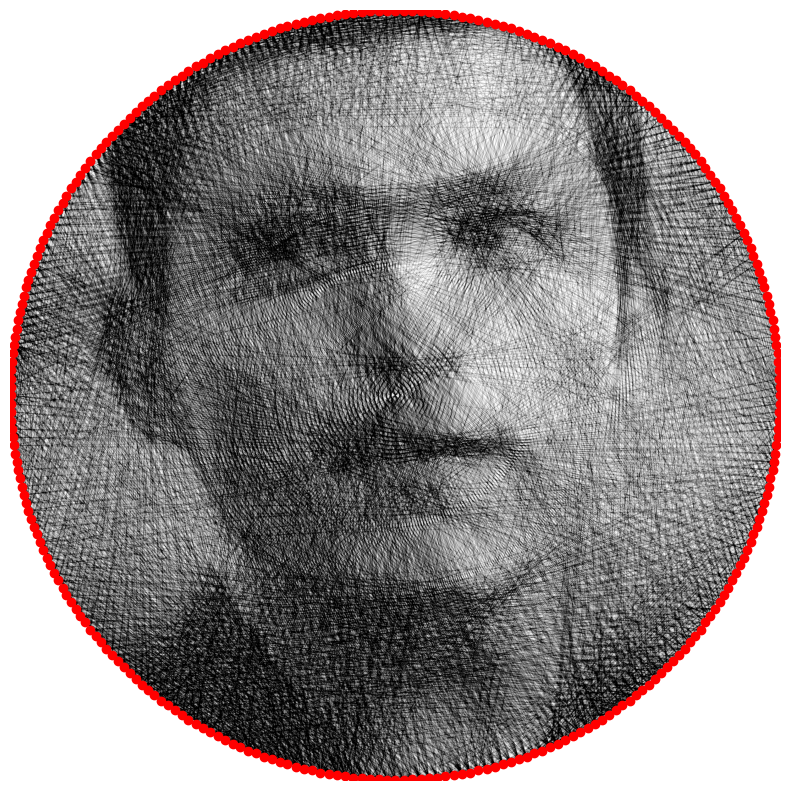

In [16]:
plt.figure(figsize=(10, 10))  
plt.imshow(final_img.img.T, cmap='gray_r', vmin=0, vmax=1)
anchors_x = [anchor.coordinates[0] for anchor in anchors]
anchors_y = [anchor.coordinates[1] for anchor in anchors]
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()  

In [17]:
save_string_art(string_art_img=string_art_img, directory="./outputs/tom7")